In [1]:
from graph.network import NetworkFrame
import networkx as nx
from book.book import Book
from glob import glob

bookpaths = glob('./texts/bible/*')

def get_text(path):
    with open(path) as f:
        return f.read()
    
book = Book(get_text(bookpaths[0]))

net = NetworkFrame(book.edges, ['node_1','node_2'])

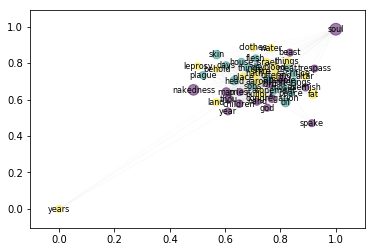

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16, 12))

net.draw_graph()